In [56]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from net import SalaryModelLinear, SalaryModelLinearDoubleReLU, loss_fn, get_optim, device, train_step, test_step
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preparing data

In [19]:
data = pd.read_csv("./surveys.csv")
data.head(3)

,Unnamed: 0,YearsCode,CompTotal,APL,Assembly,Bash/Shell,C,C#,C++,COBOL,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Turkey,Ukraine,United Kingdom of Great Britain and Northern Ireland,United States of America,DeveloperByProfession
0,2,14.0,32000.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,20.0,60000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8,6.0,46000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
data = data.drop(columns="Unnamed: 0").fillna(0)

In [21]:
Y_s = data["CompTotal"]
X_df = data.drop(columns=["CompTotal"])

In [22]:
Y_s, X_df

(0         32000.0
 1         60000.0
 2         46000.0
 3         48000.0
 4        194400.0
            ...   
 35344      8000.0
 35345     36000.0
 35346     60000.0
 35347    107000.0
 35348     58500.0
 Name: CompTotal, Length: 35349, dtype: float64,
        YearsCode  APL  Assembly  Bash/Shell    C   C#  C++  COBOL  Clojure  \
 0           14.0  0.0       0.0         0.0  0.0  1.0  1.0    0.0      0.0   
 1           20.0  0.0       0.0         0.0  0.0  1.0  0.0    0.0      0.0   
 2            6.0  0.0       0.0         0.0  0.0  0.0  0.0    0.0      0.0   
 3            5.0  0.0       0.0         1.0  0.0  1.0  0.0    0.0      0.0   
 4           12.0  0.0       0.0         0.0  0.0  1.0  0.0    0.0      0.0   
 ...          ...  ...       ...         ...  ...  ...  ...    ...      ...   
 35344        6.0  0.0       0.0         0.0  0.0  0.0  0.0    0.0      0.0   
 35345        9.0  0.0       0.0         1.0  0.0  0.0  0.0    0.0      0.0   
 35346        8.0  0.0       0.

In [23]:
X, y = torch.tensor(X_df.to_numpy(dtype=np.float32)), torch.tensor(Y_s, dtype=torch.float32)

In [24]:
X.dtype, y.dtype

(torch.float32, torch.float32)

## Splitting and moving to desired device

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train, X_test, Y_train, Y_test = X_train.to(device), X_test.to(device), Y_train.to(device), Y_test.to(device) # move to GPU

## Creating and running a neural network

In [27]:
salary_model1_100 = SalaryModelLinear(X_train.shape[1], 100, 1).to(device)
torch.manual_seed(42)

In [28]:
Y_train, Y_test = Y_train.unsqueeze(-1), Y_test.unsqueeze(-1)

In [29]:
Y_train.shape, Y_test.shape

(torch.Size([28279, 1]), torch.Size([7070, 1]))

In [30]:
Y_train, Y_test

(tensor([[2.0000e+03],
         [1.7500e+05],
         [4.1000e+06],
         ...,
         [5.3455e+04],
         [1.6400e+05],
         [1.7100e+04]], device='cuda:0'),
 tensor([[   6000.],
         [ 800000.],
         [ 124000.],
         ...,
         [  65000.],
         [  68900.],
         [1313000.]], device='cuda:0'))

In [31]:
X_train, X_test

(tensor([[ 5.,  0.,  0.,  ...,  0.,  0.,  1.],
         [17.,  0.,  0.,  ...,  0.,  0.,  1.],
         [ 5.,  0.,  0.,  ...,  0.,  0.,  1.],
         ...,
         [15.,  0.,  0.,  ...,  1.,  0.,  1.],
         [12.,  0.,  1.,  ...,  0.,  0.,  0.],
         [12.,  0.,  0.,  ...,  0.,  0.,  1.]], device='cuda:0'),
 tensor([[17.,  0.,  0.,  ...,  1.,  0.,  1.],
         [17.,  0.,  0.,  ...,  0.,  0.,  1.],
         [25.,  0.,  0.,  ...,  0.,  1.,  1.],
         ...,
         [ 6.,  0.,  0.,  ...,  0.,  1.,  1.],
         [12.,  0.,  0.,  ...,  0.,  0.,  1.],
         [ 3.,  0.,  0.,  ...,  0.,  0.,  1.]], device='cuda:0'))

In [32]:
salary_model1_100.state_dict()

OrderedDict([('layer_stack.0.weight',
              tensor([[ 0.0772,  0.0838, -0.0237,  ..., -0.0539,  0.0925, -0.0341],
                      [-0.0358, -0.0977, -0.0578,  ...,  0.0868, -0.0100, -0.0226],
                      [ 0.0015, -0.0060,  0.0243,  ..., -0.0412, -0.0912, -0.0983],
                      ...,
                      [-0.0451,  0.0258,  0.0061,  ...,  0.0057, -0.0895, -0.0376],
                      [ 0.0634,  0.0579,  0.0349,  ..., -0.0840, -0.0602,  0.0569],
                      [ 0.0392, -0.0400, -0.0081,  ..., -0.0426, -0.0664, -0.0355]],
                     device='cuda:0')),
             ('layer_stack.0.bias',
              tensor([ 0.0097,  0.0407,  0.0744,  0.0729,  0.0104,  0.0920,  0.0537,  0.0539,
                      -0.0866,  0.0083, -0.0215, -0.0960, -0.0499,  0.0769,  0.0370,  0.0934,
                       0.0689, -0.0008,  0.0908,  0.0213, -0.0148, -0.0432,  0.0651,  0.0453,
                       0.0701, -0.0175, -0.0935,  0.0183,  0.0111, -0.06

In [33]:
optimizer = get_optim(salary_model1_100.parameters(), 0.01)

In [34]:
epochs = 5000
for epoch in range(epochs):
    train_step(
        model=salary_model1_100,
        loss_fn=loss_fn,
        optimizer=optimizer,
        x=X_train,
        y=Y_train,
        epoch=epoch
    )
    test_step(
        model=salary_model1_100,
        loss_fn=loss_fn,
        optimizer=optimizer,
        x=X_test,
        y=Y_test,
        epoch=epoch
    )

Epoch 0 | Test loss: 249419.78125 | Test std 1.4556573629379272
Epoch 1 | Test loss: 249416.328125 | Test std 3.2672505378723145
Epoch 2 | Test loss: 249410.796875 | Test std 6.0226969718933105
Epoch 3 | Test loss: 249402.34375 | Test std 10.061197280883789
Epoch 4 | Test loss: 249390.125 | Test std 15.740727424621582
Epoch 5 | Test loss: 249373.203125 | Test std 23.46074676513672
Epoch 6 | Test loss: 249350.578125 | Test std 33.6262321472168
Epoch 7 | Test loss: 249321.0625 | Test std 46.768577575683594
Epoch 8 | Test loss: 249283.375 | Test std 63.504661560058594
Epoch 9 | Test loss: 249236.015625 | Test std 84.40972900390625
Epoch 10 | Test loss: 249177.421875 | Test std 110.14661407470703
Epoch 11 | Test loss: 249105.859375 | Test std 141.53990173339844
Epoch 12 | Test loss: 249019.28125 | Test std 179.57521057128906
Epoch 13 | Test loss: 248915.59375 | Test std 225.27867126464844
Epoch 14 | Test loss: 248792.75 | Test std 279.685546875
Epoch 15 | Test loss: 248648.515625 | Test st

In [39]:
salary_model1_20 = SalaryModelLinear(X_train.shape[1], 20, 1).to(device)
torch.manual_seed(42)

In [40]:
optimizer = get_optim(salary_model1_20.parameters(), 0.01)

In [41]:
epochs = 5000
for epoch in range(epochs):
    train_step(
        model=salary_model1_20,
        loss_fn=loss_fn,
        optimizer=optimizer,
        x=X_train,
        y=Y_train,
        epoch=epoch
    )
    test_step(
        model=salary_model1_20,
        loss_fn=loss_fn,
        optimizer=optimizer,
        x=X_test,
        y=Y_test,
        epoch=epoch
    )

Epoch 0 | Test loss: 249421.984375 | Test std 0.20679719746112823
Epoch 1 | Test loss: 249421.421875 | Test std 0.4519849717617035
Epoch 2 | Test loss: 249420.765625 | Test std 0.7434061765670776
Epoch 3 | Test loss: 249419.921875 | Test std 1.0982506275177002
Epoch 4 | Test loss: 249418.875 | Test std 1.5270273685455322
Epoch 5 | Test loss: 249417.5625 | Test std 2.046614408493042
Epoch 6 | Test loss: 249415.953125 | Test std 2.688830852508545
Epoch 7 | Test loss: 249413.984375 | Test std 3.4997267723083496
Epoch 8 | Test loss: 249411.578125 | Test std 4.509363174438477
Epoch 9 | Test loss: 249408.734375 | Test std 5.723782062530518
Epoch 10 | Test loss: 249405.359375 | Test std 7.157383918762207
Epoch 11 | Test loss: 249401.484375 | Test std 8.829959869384766
Epoch 12 | Test loss: 249396.921875 | Test std 10.768412590026855
Epoch 13 | Test loss: 249391.671875 | Test std 13.002883911132812
Epoch 14 | Test loss: 249385.671875 | Test std 15.567679405212402
Epoch 15 | Test loss: 249378.7

In [45]:
salary_model2_100 = SalaryModelLinearDoubleReLU(X_train.shape[1], 100, 1).to(device)
torch.manual_seed(42)

In [46]:
optimizer = get_optim(salary_model2_100.parameters(), 0.01)

In [47]:
epochs = 5000
for epoch in range(epochs):
    train_step(
        model=salary_model2_100,
        loss_fn=loss_fn,
        optimizer=optimizer,
        x=X_train,
        y=Y_train,
        epoch=epoch
    )
    test_step(
        model=salary_model2_100,
        loss_fn=loss_fn,
        optimizer=optimizer,
        x=X_test,
        y=Y_test,
        epoch=epoch
    )

Epoch 0 | Test loss: 249421.1875 | Test std 0.6332820057868958
Epoch 1 | Test loss: 249419.5625 | Test std 1.4852294921875
Epoch 2 | Test loss: 249416.9375 | Test std 2.801253318786621
Epoch 3 | Test loss: 249412.859375 | Test std 4.750982284545898
Epoch 4 | Test loss: 249406.921875 | Test std 7.496913909912109
Epoch 5 | Test loss: 249398.640625 | Test std 11.2272367477417
Epoch 6 | Test loss: 249387.484375 | Test std 16.16948890686035
Epoch 7 | Test loss: 249372.8125 | Test std 22.601272583007812
Epoch 8 | Test loss: 249353.953125 | Test std 30.870824813842773
Epoch 9 | Test loss: 249330.171875 | Test std 41.33297348022461
Epoch 10 | Test loss: 249300.796875 | Test std 54.31919479370117
Epoch 11 | Test loss: 249264.875 | Test std 70.20677947998047
Epoch 12 | Test loss: 249221.5625 | Test std 89.40603637695312
Epoch 13 | Test loss: 249169.875 | Test std 112.3294906616211
Epoch 14 | Test loss: 249108.84375 | Test std 139.443359375
Epoch 15 | Test loss: 249037.296875 | Test std 171.24554

## Testing

In [49]:
X_test.shape

torch.Size([7070, 98])

In [50]:
graph_data_input = X_test[:100]

In [51]:
salary_model1_100_y = salary_model1_100(graph_data_input)

In [52]:
salary_model1_20_y = salary_model1_20(graph_data_input)

In [53]:
salary_model2_100_y = salary_model2_100(graph_data_input)

In [54]:
salary_model1_100_y

tensor([[7.6564e+04],
        [8.3166e+05],
        [1.7356e+05],
        [2.0306e+05],
        [1.4497e+05],
        [1.5485e+05],
        [2.8168e+04],
        [1.5457e+05],
        [1.4688e+05],
        [5.5069e+04],
        [7.5194e+05],
        [1.1134e+05],
        [6.7696e+04],
        [1.8075e+05],
        [9.6474e+04],
        [6.3519e+04],
        [1.7255e+05],
        [2.7442e+04],
        [1.3812e+04],
        [1.3982e+05],
        [1.6476e+05],
        [5.0448e+04],
        [1.5471e+05],
        [6.3717e+04],
        [1.9061e+05],
        [2.7755e+06],
        [4.6944e+04],
        [6.0031e+04],
        [9.4465e+04],
        [1.9369e+05],
        [1.1539e+05],
        [1.4789e+05],
        [5.2355e+04],
        [2.7297e+05],
        [1.5525e+05],
        [7.6833e+03],
        [1.3158e+05],
        [4.9105e+04],
        [1.2816e+05],
        [1.3974e+03],
        [1.4581e+05],
        [1.8067e+05],
        [1.4476e+06],
        [3.9646e+04],
        [7.0751e+04],
        [8

In [ ]:
fig, ax = plt.subplots()

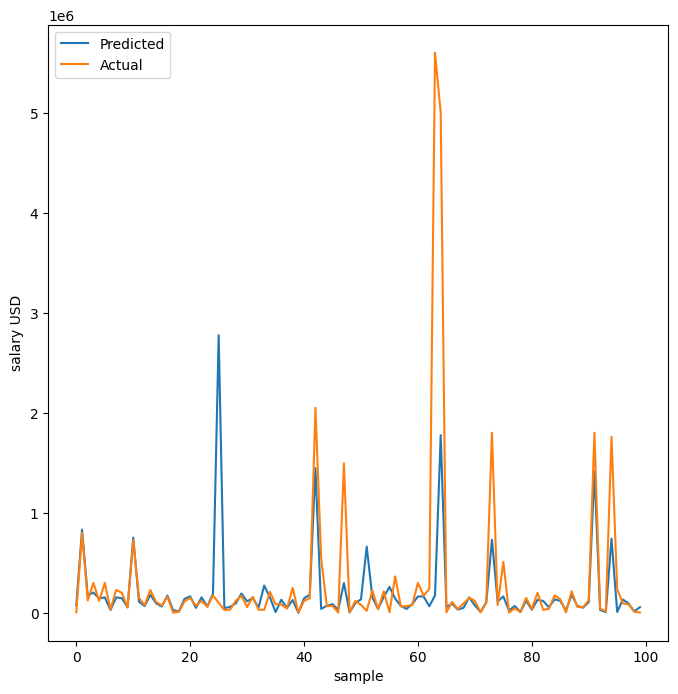

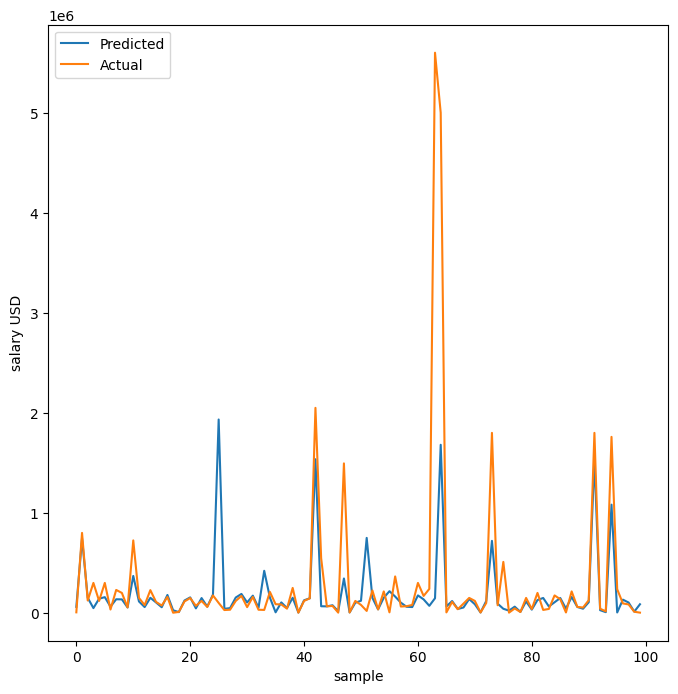

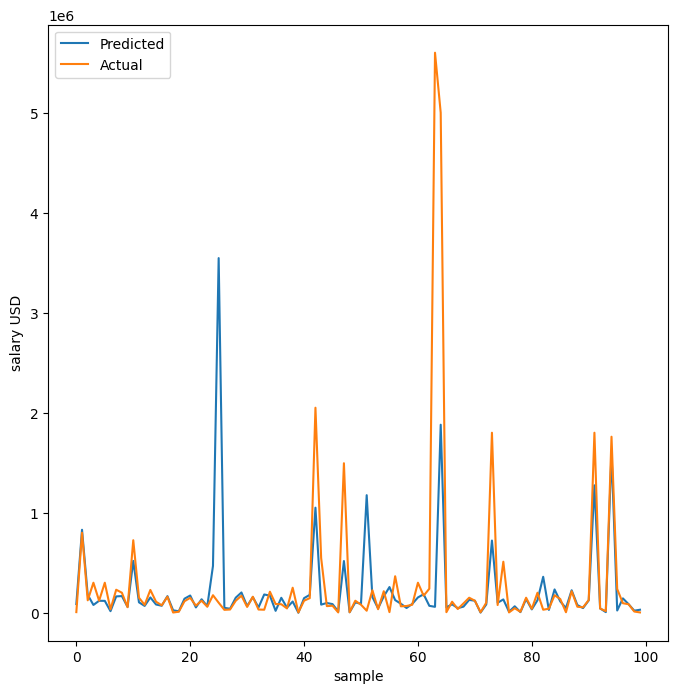

In [69]:
names = ["model1_100", "model1_20", "model2_100"]
for index, data in enumerate([salary_model1_100_y, salary_model1_20_y, salary_model2_100_y]):
    plt.figure(figsize=(8, 8))
    plt.xlabel("sample")
    plt.ylabel("salary USD")
    plt.plot(list(range(100)), data.to("cpu").detach(), label="Predicted")
    plt.plot(list(range(100)), Y_test[:100].to("cpu"), label="Actual")
    plt.legend(loc="upper left")
    plt.savefig(f"./outputs/{names[index]}.png")